In [130]:
import pandas as pd
import numpy as np
import os
import sys

import matplotlib.pyplot as plt
from datetime import timedelta
# Make `src` dir can be imported
project_root_path = os.path.abspath(os.path.join(os.getcwd(), '..'))  # /aicup-predict-energy-generation
sys.path.append(project_root_path)  


from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

In [6]:
df_sunlight = pd.read_csv('../data/processed_data/sunlight_simulation_data.csv')
df_sunlight['datetime'] = pd.to_datetime(df_sunlight['datetime'])

In [7]:
df_sunlight.head()

,datetime,windspeed,pressure,temperature,humidity,sunlight,power,device
0,2024-03-02 06:06:47,0.0,1020.13,14.18,94.37,22.50,0.0,L10
1,2024-03-02 06:07:47,0.0,1020.10,14.19,94.27,28.33,0.0,L10
2,2024-03-02 06:08:47,0.0,1020.07,14.19,94.35,34.17,0.0,L10
3,2024-03-02 06:09:47,0.0,1020.07,14.19,94.42,35.83,0.0,L10
4,2024-03-02 06:10:47,0.0,1020.04,14.20,94.46,37.50,0.0,L10


In [8]:
df_sunlight['date'] = df_sunlight['datetime'].dt.date
df_sunlight['hour'] = df_sunlight['datetime'].dt.hour
df_sunlight

,datetime,windspeed,pressure,temperature,humidity,sunlight,power,device,date,hour
0,2024-03-02 06:06:47,0.00,1020.13,14.18,94.37,22.50,0.0,L10,2024-03-02,6
1,2024-03-02 06:07:47,0.00,1020.10,14.19,94.27,28.33,0.0,L10,2024-03-02,6
2,2024-03-02 06:08:47,0.00,1020.07,14.19,94.35,34.17,0.0,L10,2024-03-02,6
3,2024-03-02 06:09:47,0.00,1020.07,14.19,94.42,35.83,0.0,L10,2024-03-02,6
4,2024-03-02 06:10:47,0.00,1020.04,14.20,94.46,37.50,0.0,L10,2024-03-02,6
...,...,...,...,...,...,...,...,...,...,...
85723,2024-07-21 18:44:27,0.00,1005.26,32.27,67.49,37.50,0.0,L10,2024-07-21,18
85724,2024-07-21 18:45:27,0.00,1005.24,32.26,67.12,32.50,0.0,L10,2024-07-21,18
85725,2024-07-21 18:46:27,0.52,1005.25,32.24,67.05,28.33,0.0,L10,2024-07-21,18
85726,2024-07-21 18:47:27,0.26,1005.27,32.18,67.28,24.17,0.0,L10,2024-07-21,18


In [9]:
hour_for_sub = [10, 11, 12]
df_sunlight['new_sunlight'] = df_sunlight.apply(lambda x: x['sunlight'] if x['hour'] not in hour_for_sub else None, axis=1)

In [10]:
df_sunlight[df_sunlight['hour'].isin(hour_for_sub)].new_sunlight.value_counts()

Series([], Name: count, dtype: int64)

In [202]:
for date in df_sunlight.date.unique().tolist():
    df_date = df_sunlight[df_sunlight['date'] == date].set_index('datetime')

In [203]:
df_date.set_index(pd.date_range(start=df_date.index[0], end=df_date.index[-1], freq='min'), inplace=True)

In [ ]:
# df_date.new_sunlight.to_csv('../data/processed_data/new_sunlight_test.csv')

In [226]:
one = pd.Timedelta(minutes=1)
firstTS = df_date[df_date['hour'] < 10].new_sunlight.copy()
secondTS = df_date[df_date['hour'] > 13].new_sunlight.copy()

firstTSr = firstTS[::-1].copy()
secondTSr = secondTS[::-1].copy()

indexr = pd.date_range(start=firstTS.index[0], end=secondTS.index[-1], freq='min')
firstTSr.index = indexr[-len(firstTSr):]
secondTSr.index = indexr[:len(secondTSr)]

In [227]:
secondTSr

2024-07-21 05:08:26      20.83
2024-07-21 05:09:26      24.17
2024-07-21 05:10:26      28.33
2024-07-21 05:11:26      32.50
2024-07-21 05:12:26      37.50
                        ...   
2024-07-21 09:52:26    4396.67
2024-07-21 09:53:26    4382.50
2024-07-21 09:54:26    4350.83
2024-07-21 09:55:26    4335.83
2024-07-21 09:56:26    4335.00
Freq: min, Name: new_sunlight, Length: 289, dtype: float64

In [234]:
seasonal_periods = 70
#FORWARD    
es = ExponentialSmoothing(firstTS, seasonal=None, trend='add').fit()
forwardPrediction = es.predict(start=firstTS.index[-1]+one, end=secondTS.index[0]-one)

#BACKWARD
es = ExponentialSmoothing(secondTSr, seasonal=None, trend='add').fit()
backwardPrediction = es.predict(start=secondTSr.index[-1]+one, end=firstTSr.index[0]-one)

l = len(forwardPrediction)
interpolation = pd.Series([(backwardPrediction[i] * i + forwardPrediction[i] * (l -i) )/ l for i in range(l)], index=forwardPrediction.index.copy())

e:\miniconda3\envs\aicup-energy\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Sean\AppData\Local\Temp\ipykernel_18912\3128998962.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  interpolation = pd.Series([(backwardPrediction[i] * i + forwardPrediction[i] * (l -i) )/ l for i in range(l)], index=forwardPrediction.index.copy())


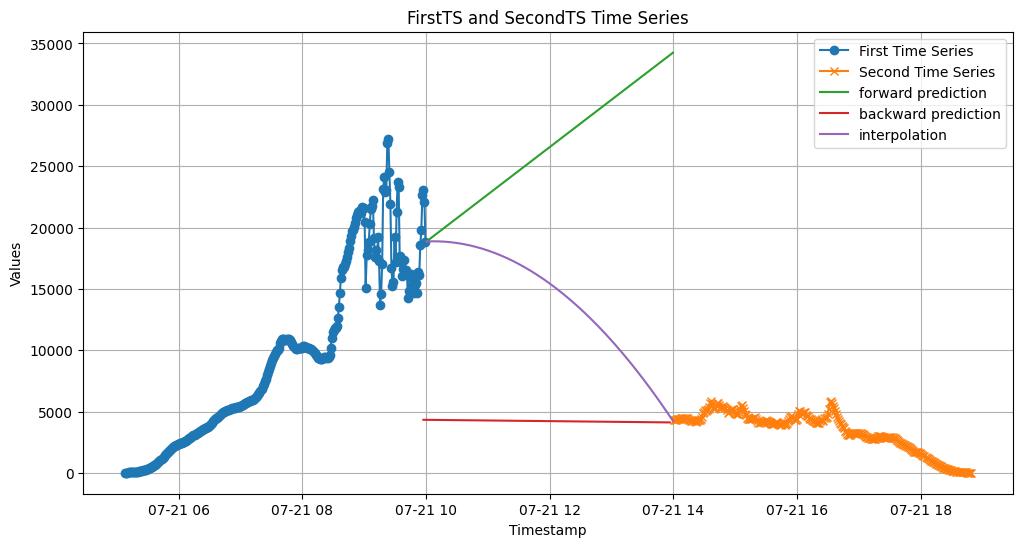

: 

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(firstTS, label='First Time Series', marker='o')
plt.plot(secondTS, label='Second Time Series', marker='x')
plt.plot(forwardPrediction, label='forward prediction')
plt.plot(backwardPrediction, label='backward prediction')
plt.plot(interpolation, label='interpolation')
plt.title('FirstTS and SecondTS Time Series')
plt.xlabel('Timestamp')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

In [ ]:
df_test = df_date[['new_sunlight']]

In [182]:
df_test['new_sunlight_interpolated'] = df_test['new_sunlight'].interpolate(method='spline', order=4)

C:\Users\Sean\AppData\Local\Temp\ipykernel_18912\965692540.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['new_sunlight_interpolated'] = df_test['new_sunlight'].interpolate(method='spline', order=4)


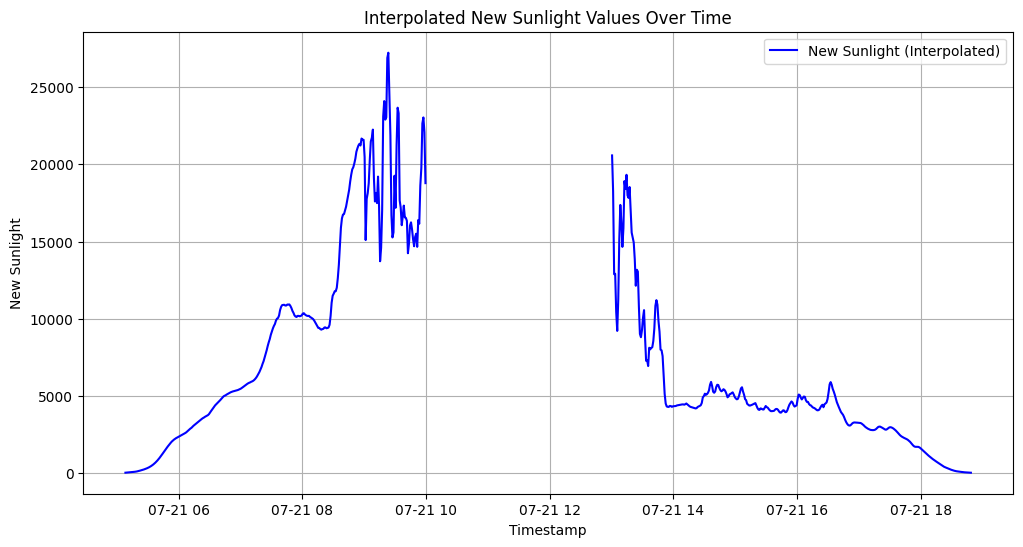

In [184]:
plt.figure(figsize=(12, 6))
plt.plot(df_test.index, df_test['new_sunlight'], label='New Sunlight (Interpolated)', color='blue')
plt.title('Interpolated New Sunlight Values Over Time')
plt.xlabel('Timestamp')
plt.ylabel('New Sunlight')
plt.legend()
plt.grid()
plt.show()

In [ ]:
test=2